In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,KBinsDiscretizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
import xgboost
import random
import pickle
warnings.simplefilter(action='ignore',category=FutureWarning)
random.seed(0)
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Reading the data
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Final Project/Online Shoppers Intention/online_shoppers_intention.csv')

In [3]:
# Top 5 
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
# Checking Data types
df.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

In [5]:
# Columns seperation
bin_cols = ['Administrative','Informational','ProductRelated']
ohe_cols = ['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','SpecialDay','Weekend','Revenue']
num_cols = ['Administrative_Duration','Informational_Duration','ProductRelated_Duration','BounceRates','ExitRates','PageValues']

In [6]:
len(df.columns.to_list())

18

In [7]:
# Binning the Columns
for col in bin_cols:
  df[col] = pd.cut(df[col],bins=3,labels=['Low','Medium','High'])

In [8]:
# Changing the Categorical Column types to category
for col in ohe_cols:
  df[col] = df[col].astype('category')

In [9]:
# Storing categorical feature names
cat_cols = df.select_dtypes('category').columns.to_list()

In [10]:
# Applying statistical tests for all the categorical columns using chi square test
test_scores = {}
for col in cat_cols:
  test_scores[col]={}
  ct = pd.crosstab(df['Revenue'],df[col])
  score = stats.chi2_contingency(ct)
  test_scores[col]['pvalue'] = score[1]
  test_scores[col]['test statistic'] = score[0]

In [11]:
cat_test_scores = pd.DataFrame(test_scores).T

In [12]:
# Categorical Test Scores
cat_test_scores

,pvalue,test statistic
Administrative,1.666846e-10,45.029836
Informational,4.314159e-02,6.286536
ProductRelated,3.858402e-08,34.140855
SpecialDay,3.543244e-19,96.076906
Month,2.238786e-77,384.934762
OperatingSystems,1.416094e-13,75.027056
Browser,6.087543e-03,27.715299
Region,3.214250e-01,9.252751
TrafficType,1.652735e-67,373.145565
VisitorType,4.269904e-30,135.251923


In [13]:
# Checking for p claues more than critical value
cat_test_scores[cat_test_scores['pvalue']>0.05]

,pvalue,test statistic
Region,0.321425,9.252751


In [14]:
# Dropping the insignificant feature
cat_test_scores.T.drop('Region',1,inplace=True)

In [15]:
cat_test_scores

,pvalue,test statistic
Administrative,1.666846e-10,45.029836
Informational,4.314159e-02,6.286536
ProductRelated,3.858402e-08,34.140855
SpecialDay,3.543244e-19,96.076906
Month,2.238786e-77,384.934762
OperatingSystems,1.416094e-13,75.027056
Browser,6.087543e-03,27.715299
Region,3.214250e-01,9.252751
TrafficType,1.652735e-67,373.145565
VisitorType,4.269904e-30,135.251923


In [16]:
# Storing a list of significant categorical features
cat_significant_features = cat_test_scores.index.to_list()
cat_significant_features

['Administrative',
 'Informational',
 'ProductRelated',
 'SpecialDay',
 'Month',
 'OperatingSystems',
 'Browser',
 'Region',
 'TrafficType',
 'VisitorType',
 'Weekend',
 'Revenue']

In [17]:
# Storing the numerical feature names
num_cols = df.select_dtypes(exclude='category').columns.to_list()
num_cols

['Administrative_Duration',
 'Informational_Duration',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues']

In [18]:
# Applying Statistical Tests on Numerical columns using independant t tests
test_scores = {}
for col in num_cols:
  test_scores[col]={}
  r_t = df[df['Revenue']==True][col]
  r_f = df[df['Revenue']==False][col]
  score = stats.ttest_ind(r_t,r_f)
  test_scores[col]['pvalue']=score[1]
  test_scores[col]['test statistic'] = score[0]

In [19]:
num_test_scores = pd.DataFrame(test_scores).T
num_test_scores

,pvalue,test statistic
Administrative_Duration,2.146514e-25,10.436882
Informational_Duration,5.282871e-15,7.829854
ProductRelated_Duration,6.115338e-65,17.118049
BounceRates,1.594198e-63,-16.922638
ExitRates,1.662654e-119,-23.500777
PageValues,0.000000e+00,62.843162


In [20]:
# Checking for p values more than critical value
num_test_scores[num_test_scores['pvalue']>0.05]

,pvalue,test statistic


In [21]:
# Storing Significant Categorical Features
num_significant_features = num_test_scores.index.to_list()
num_significant_features

['Administrative_Duration',
 'Informational_Duration',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues']

In [22]:
# All the significant features
sig_features = num_significant_features+cat_significant_features
sig_features

['Administrative_Duration',
 'Informational_Duration',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues',
 'Administrative',
 'Informational',
 'ProductRelated',
 'SpecialDay',
 'Month',
 'OperatingSystems',
 'Browser',
 'Region',
 'TrafficType',
 'VisitorType',
 'Weekend',
 'Revenue']

In [23]:
# Storing significant features in another dataframe
main_df = df[sig_features]

In [24]:
main_df.head(3)

,Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates,ExitRates,PageValues,Administrative,Informational,ProductRelated,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.2,0.2,0.0,Low,Low,Low,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,64.0,0.0,0.1,0.0,Low,Low,Low,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,0.0,0.0,0.2,0.2,0.0,Low,Low,Low,0.0,Feb,4,1,9,3,Returning_Visitor,False,False


In [25]:
main_df.dtypes

Administrative_Duration     float64
Informational_Duration      float64
ProductRelated_Duration     float64
BounceRates                 float64
ExitRates                   float64
PageValues                  float64
Administrative             category
Informational              category
ProductRelated             category
SpecialDay                 category
Month                      category
OperatingSystems           category
Browser                    category
Region                     category
TrafficType                category
VisitorType                category
Weekend                    category
Revenue                    category
dtype: object

In [26]:
ss = StandardScaler()
ohe = OneHotEncoder()

In [27]:
sm = SMOTE(random_state=0)

In [28]:
# Splitting independant features and the target features
main_X = main_df.drop('Revenue',1)
main_y = main_df['Revenue'].astype(bool)

# Data Preparation

In [29]:
# Seperating categorical columns and numercial columns
cat_cols = main_X.select_dtypes('category').columns.to_list()
num_cols = main_X.select_dtypes(exclude='category').columns.to_list()

In [30]:
# Categorical Pipeline
cat_pipeline = Pipeline([
                         ('encoding',OneHotEncoder())
])

In [31]:
# Numerical Pipeline
num_pipeline = Pipeline([
                         ('scaling',StandardScaler())
])

In [32]:
# Complete Pipeline
prep_data = ColumnTransformer([
                               ('Categoricals',cat_pipeline,cat_cols),
                               ('Numericals',num_pipeline,num_cols)
])

In [33]:
# Splitting the data into training and validation data
X_train,X_valid,y_train,y_valid = train_test_split(main_X,main_y,random_state=1,test_size=0.2,stratify=main_y)

In [34]:
# passing the training data through the pipeline
X_train = prep_data.fit_transform(X_train)

In [35]:
# passing the validation data throught the pipeline
X_valid = prep_data.transform(X_valid)

In [36]:
# Smote application of the training data
sm_X,sm_y = sm.fit_resample(X_train,y_train)

In [37]:
# Splitting the smotted data into training and test data
X_train,X_test,y_train,y_test = train_test_split(sm_X,sm_y,test_size=0.2,random_state=0,stratify=sm_y)

In [38]:
pd.DataFrame(X_valid.toarray()).to_csv('X_valid.csv',index=False)
pd.DataFrame(y_valid).to_csv('y_valid.csv',index=False)
pd.DataFrame(X_train.toarray()).to_csv('X_train.csv',index=False)
pd.DataFrame(y_train).to_csv('y_train.csv',index=False)
pd.DataFrame(X_test.toarray()).to_csv('X_test.csv',index=False)
pd.DataFrame(y_test).to_csv('y_test.csv',index=False)
pd.DataFrame(sm_X.toarray()).to_csv('cross_validation_X.csv',index=False)
pd.DataFrame(sm_y).to_csv('cross_validation_y.csv',index=False)

# Logistic Regression

In [39]:
# Logistic Regression Model
lr = LogisticRegression(random_state=0,max_iter=10000) 

In [40]:
# Fitting the train data
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
# y Pred
y_pred = lr.predict(X_test)

In [42]:
print(f'Accuracy Score of the model is {accuracy_score(y_test,y_pred)}')

Accuracy Score of the model is 0.8276378896882494


In [43]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.82      0.84      0.83      1668
        True       0.84      0.82      0.83      1668

    accuracy                           0.83      3336
   macro avg       0.83      0.83      0.83      3336
weighted avg       0.83      0.83      0.83      3336



In [44]:
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

In [46]:
params = [
          {
              'penalty':['l2'],
              'solver':['newton-cg','sag','lbfgs'],
              'C':np.arange(0,1.1,0.1)
          },
          {
              'penalty':['elasticnet'],
              'solver':['saga'],
              'C':np.arange(0,1.1,0.1)
          },
          {
              'penalty':['l1'],
              'solver':['liblinear'],
              'C':np.arange(0,1.1,0.1)
          },
          {
              'penalty':['none'],
              'solver':['newton-cg','sag','lbfgs','saga'],
          }
]

In [47]:
lr = LogisticRegression(random_state=0,max_iter=10000)

In [48]:
gs = GridSearchCV(estimator=lr,param_grid=params,scoring='accuracy',n_jobs=-1,cv=cv)

In [49]:
gs.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated',...
                         {'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                          'penalty': ['elasticnet'], 'solver': ['saga']},
                         {'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                          'pen

In [50]:
gs.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}

In [51]:
base_model = gs.best_estimator_
base_model

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
base_model.fit(X_train,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
y_pred = base_model.predict(X_test)

In [54]:
print(f'Accuracy score of the test data is {accuracy_score(y_test,y_pred)}')
print(f'Recall score of the test data is {recall_score(y_test,y_pred)}')

Accuracy score of the test data is 0.8252398081534772
Recall score of the test data is 0.8129496402877698


In [55]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.82      0.84      0.83      1668
        True       0.83      0.81      0.82      1668

    accuracy                           0.83      3336
   macro avg       0.83      0.83      0.83      3336
weighted avg       0.83      0.83      0.83      3336



In [56]:
lr_scores = {
    'recall scores':[],
    'accuracy scores':[]
}
for i in np.arange(0.1,1,0.1):
  y_new_pred = base_model.predict_proba(X_test)[:,0]<i
  lr_scores['recall scores'].append(recall_score(y_test,y_new_pred))
  lr_scores['accuracy scores'].append(accuracy_score(y_test,y_new_pred))

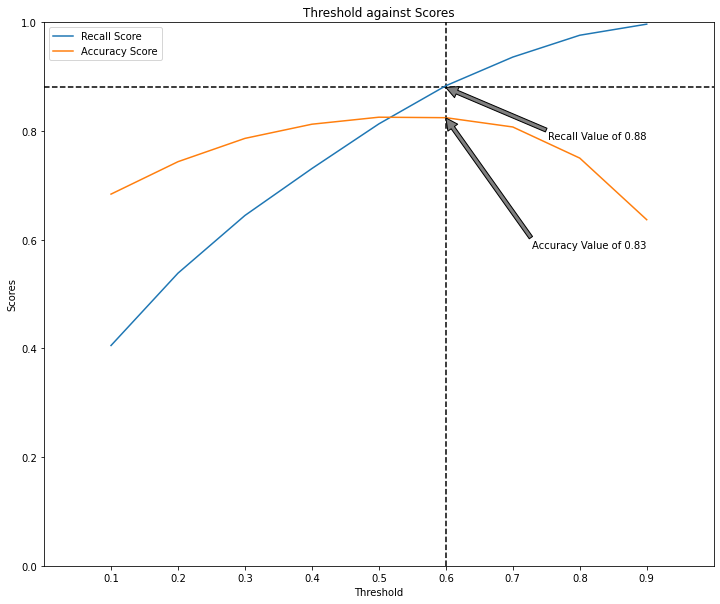

In [77]:
plt.figure(figsize=(12,10))
plt.title('Threshold against Scores')
plt.plot(np.arange(0.1,1,0.1),lr_scores['recall scores'],label='Recall Score')
plt.plot(np.arange(0.1,1,0.1),lr_scores['accuracy scores'],label='Accuracy Score')
plt.vlines(x=0.6,ymin=0,ymax=1,ls='--')
plt.hlines(y=0.88,xmin=0,xmax=1,ls='--')
plt.ylim(0,1)
plt.xlim(0,1)
plt.xticks(ticks=np.arange(0.1,1,0.1))
plt.annotate(('Recall Value of 0.88'),xy=(0.6,0.88),xytext=(0.9, 0.8),arrowprops=dict(facecolor='grey'),horizontalalignment='right', verticalalignment='top')
plt.annotate(('Accuracy Value of 0.83'),xy=(0.6,0.824),xytext=(0.9, 0.6),arrowprops=dict(facecolor='grey'),horizontalalignment='right', verticalalignment='top')
plt.xlabel('Threshold')
plt.ylabel('Scores')
plt.legend(loc='best')
plt.savefig('Logistic Regression Recall against Accuracy')
plt.show()

In [78]:
y_pred = base_model.predict_proba(X_test)[:,0]<0.6

In [79]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.87      0.77      0.82      1668
        True       0.79      0.89      0.84      1668

    accuracy                           0.83      3336
   macro avg       0.83      0.83      0.83      3336
weighted avg       0.83      0.83      0.83      3336



In [59]:
print(f'New Threshold Accuracy Score :{accuracy_score(y_test,y_pred)}')
print(f'New Threshold Recall Score :{recall_score(y_test,y_pred)}')

New Threshold Accuracy Score :0.8243405275779376
New Threshold Recall Score :0.8830935251798561


In [62]:
sm_Xdf = pd.DataFrame(sm_X.toarray())

In [60]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

In [81]:
kfold = kf.split(sm_Xdf,sm_y)

In [82]:
lrrecscores = []
lraccscores = []
for k,(train,test) in enumerate(kfold):
    base_model.fit(sm_Xdf.iloc[train,:],sm_y[train])
    # y_pred = base_model.predict_proba(sm_Xdf.iloc[test,:])[:,0]<0.6
    y_pred = base_model.predict(sm_Xdf.iloc[test,:])
    lrrecscores.append(recall_score(sm_y[test],y_pred))
    lraccscores.append(accuracy_score(sm_y[test],y_pred))

In [83]:
lrrecscores

[0.8081534772182254,
 0.8044391121775645,
 0.8050389922015597,
 0.7997601918465228,
 0.815947242206235]

In [84]:
lraccscores

[0.8336330935251799,
 0.8332833583208396,
 0.8383808095952024,
 0.8239880059970015,
 0.8350824587706147]

In [87]:
print(f'Logistic Regression, Average Recall Score for the Cross Validated Model is {np.mean(lrrecscores)}')
print(f'Logistic Regression, Variance of the Recall Scores of the Cross Validated Model is {np.std(lrrecscores,ddof=1)}')

Logistic Regression, Average Recall Score for the Cross Validated Model is 0.8066678031300214
Logistic Regression, Variance of the Recall Scores of the Cross Validated Model is 0.005992712222184504


In [88]:
print(f'Logistic Regression, Average Accuracy Score for the Cross Validated Model is {np.mean(lraccscores)}')
print(f'Logistic Regression,Variance of the Accuracy Scores of the Cross Validated Model is {np.std(lraccscores,ddof=1)}')

Logistic Regression, Average Accuracy Score for the Cross Validated Model is 0.8328735452417675
Logistic Regression,Variance of the Accuracy Scores of the Cross Validated Model is 0.005359732448113184


# Decision Tree Classifier

In [89]:
# Decision Tree Model
dt = DecisionTreeClassifier(random_state=0)

In [90]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [91]:
y_pred = dt.predict(X_test)

In [92]:
print(f'Accuracy Score for the Decision Tree :{accuracy_score(y_test,y_pred)}')
print(f'Recall Score for Decision Tree:{recall_score(y_test,y_pred)}')

Accuracy Score for the Decision Tree :0.894484412470024
Recall Score for Decision Tree:0.9124700239808153


In [93]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.91      0.88      0.89      1668
        True       0.88      0.91      0.90      1668

    accuracy                           0.89      3336
   macro avg       0.89      0.89      0.89      3336
weighted avg       0.89      0.89      0.89      3336



In [94]:
dt = DecisionTreeClassifier(random_state=0)

In [95]:
params = {
    'criterion':['gini','entropy'],
    'splitter':['best'],
    'max_features':[None,'sqrt','log2'],
}

In [96]:
gs = GridSearchCV(dt,params,scoring='accuracy',cv=cv,n_jobs=-1)

In [97]:
gs.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
 

In [98]:
gs.best_params_

{'criterion': 'gini', 'max_features': None, 'splitter': 'best'}

In [99]:
gs.best_score_

0.8981259370314841

In [100]:
dt = gs.best_estimator_
dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [101]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [102]:
y_pred = dt.predict(X_test)

In [103]:
print(f'Tuned Decision Tree Accuracy score:{accuracy_score(y_test,y_pred)}')
print(f'Tuned Decision Tree Recall score:{recall_score(y_test,y_pred)}')

Tuned Decision Tree Accuracy score:0.894484412470024
Tuned Decision Tree Recall score:0.9124700239808153


In [104]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.91      0.88      0.89      1668
        True       0.88      0.91      0.90      1668

    accuracy                           0.89      3336
   macro avg       0.89      0.89      0.89      3336
weighted avg       0.89      0.89      0.89      3336



In [106]:
gs.best_params_

{'criterion': 'gini', 'max_features': None, 'splitter': 'best'}

In [107]:
dtacc = []
dtrecall = []
for i in np.arange(0,1.1,0.1):
  dt = DecisionTreeClassifier(criterion='gini',splitter='best',max_features=None,ccp_alpha=i,random_state=0)
  dt.fit(X_train,y_train)
  y_pred = dt.predict(X_test)
  dtacc.append(accuracy_score(y_test,y_pred))
  dtrecall.append(recall_score(y_test,y_pred))

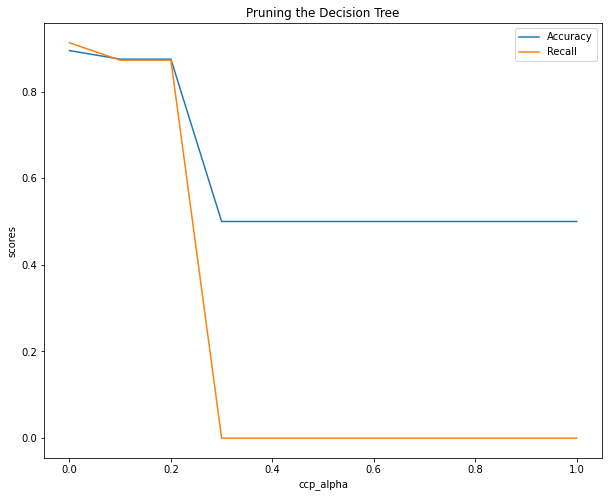

In [108]:
plt.figure(figsize=(10,8))
plt.title('Pruning the Decision Tree')
plt.plot(np.arange(0,1.1,0.1),dtacc,label='Accuracy')
plt.plot(np.arange(0,1.1,0.1),dtrecall,label='Recall')
plt.xlabel('ccp_alpha')
plt.ylabel('scores')
plt.legend(loc='best')
plt.savefig('Pruning Decision Tree')
plt.show()

In [109]:
dt = DecisionTreeClassifier(ccp_alpha=0.0,criterion='gini',random_state=0)

In [110]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [111]:
y_pred = dt.predict(X_test)

In [113]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.91      0.88      0.89      1668
        True       0.88      0.91      0.90      1668

    accuracy                           0.89      3336
   macro avg       0.89      0.89      0.89      3336
weighted avg       0.89      0.89      0.89      3336



In [115]:
print(f'Decision Tree, Recall Score of the test set is {recall_score(y_test,y_pred)}')
print(f'Decision Tree, Accuracy Score of the test set is {accuracy_score(y_test,y_pred)}')

Decision Tree, Recall Score of the test set is 0.9124700239808153
Decision Tree, Accuracy Score of the test set is 0.894484412470024


In [120]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
splits = kf.split(sm_X,sm_y)

In [121]:
dtrecscores = []
dtaccscores = []
for split,(train,test) in enumerate(splits):
  dt.fit(sm_X[train,:],sm_y[train])
  y_pred = dt.predict(sm_X[test,:])
  dtrecscores.append(recall_score(sm_y[test],y_pred))
  dtaccscores.append(accuracy_score(sm_y[test],y_pred))

In [122]:
dtrecscores

[0.9160671462829736,
 0.910617876424715,
 0.910617876424715,
 0.9100719424460432,
 0.9112709832134293]

In [131]:
print(f'The Average Accuracy Score of the Decision Tree model is {np.mean(dtaccscores)}')
print(f'The Variance of the Accuracy Scores of the Decision Tree model is {np.std(dtaccscores,ddof=1)}')

The Average Accuracy Score of the Decision Tree model is 0.9023747299012363
The Variance of the Accuracy Scores of the Decision Tree model is 0.005067681740485135


In [123]:
print(f'The Average Recall Score of the Decision Tree model is {np.mean(dtrecscores)}')
print(f'The Variance of the Recall Scores of the Decision Tree model is {np.std(dtrecscores,ddof=1)}')

The Average Recall Score of the Decision Tree model is 0.9117291649583752
The Variance of the Recall Scores of the Decision Tree model is 0.0024619262453125655


In [128]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [129]:
y_pred = dt.predict(X_test)

In [130]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.91      0.88      0.89      1668
        True       0.88      0.91      0.90      1668

    accuracy                           0.89      3336
   macro avg       0.89      0.89      0.89      3336
weighted avg       0.89      0.89      0.89      3336



# Random Forest

In [132]:
rf = RandomForestClassifier(random_state=0)

In [133]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [134]:
y_pred = rf.predict(X_test)

In [135]:
print(f'Accuracy Score of Random Forest Classifier :{accuracy_score(y_test,y_pred)}')
print(f'Recall Score of Random Forest Classifier :{recall_score(y_test,y_pred)}')

Accuracy Score of Random Forest Classifier :0.9391486810551559
Recall Score of Random Forest Classifier :0.959832134292566


In [136]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.96      0.92      0.94      1668
        True       0.92      0.96      0.94      1668

    accuracy                           0.94      3336
   macro avg       0.94      0.94      0.94      3336
weighted avg       0.94      0.94      0.94      3336



In [ ]:
rfacc = []
rfrecall = []
for i in np.arange(100,2001,100):
  rf = RandomForestClassifier(n_estimators=i,random_state=0)
  rf.fit(X_train,y_train)
  y_pred = rf.predict(X_test)
  rfacc.append(accuracy_score(y_test,y_pred))

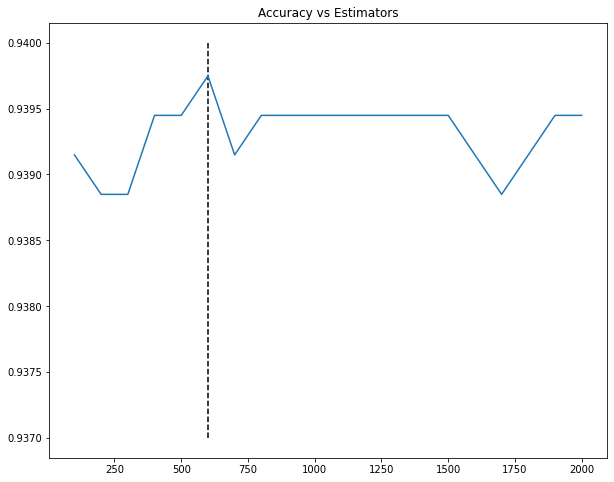

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Accuracy vs Estimators')
plt.plot(np.arange(100,2001,100),rfacc,label='Accuracy')
plt.vlines(x=600,ymin=0.937,ymax=0.94,ls='--')
plt.show()

In [137]:
rf = RandomForestClassifier(n_estimators=600,criterion='gini',random_state=0)

In [138]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [139]:
y_pred = rf.predict(X_test)

In [140]:
print(f'Random Forest Accuracy Score:{accuracy_score(y_test,y_pred)}')
print(f'Random Forest Recall Score:{recall_score(y_test,y_pred)}')

Random Forest Accuracy Score:0.939748201438849
Random Forest Recall Score:0.9592326139088729


In [141]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.96      0.92      0.94      1668
        True       0.92      0.96      0.94      1668

    accuracy                           0.94      3336
   macro avg       0.94      0.94      0.94      3336
weighted avg       0.94      0.94      0.94      3336



In [144]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
splits = kf.split(sm_X,sm_y)

In [145]:
rfrecscores = []
rfaccscores = []
for split,(train,test) in enumerate(splits):
  rf.fit(sm_X[train,:],sm_y[train])
  y_pred = rf.predict(sm_X[test,:])
  rfrecscores.append(recall_score(sm_y[test],y_pred))
  rfaccscores.append(accuracy_score(sm_y[test],y_pred))

In [146]:
print(f'Tuned Random Forest Classifier Average Accuracy Score:{np.mean(rfaccscores)}')
print(f'Tuned Random Forest Classifier Variance Scores:{np.std(rfaccscores,ddof=1)}')

Tuned Random Forest Classifier Average Accuracy Score:0.9399739518729844
Tuned Random Forest Classifier Variance Scores:0.005422925808685955


In [147]:
print(f'Tuned Random Forest Classifier Average Recall Score:{np.mean(rfrecscores)}')
print(f'Tuned Random Forest Classifier Variance Scores:{np.std(rfrecscores,ddof=1)}')

Tuned Random Forest Classifier Average Recall Score:0.9565834315151358
Tuned Random Forest Classifier Variance Scores:0.005073163648892156


In [ ]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
print(f'Accuracy Score for the Tuned Random Forest is {accuracy_score(y_test,y_pred)}')
print(f'Recall Score for the Tuned Random Forest is {recall_score(y_test,y_pred)}')

Accuracy Score for the Tuned Random Forest is 0.939748201438849
Recall Score for the Tuned Random Forest is 0.9592326139088729


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.96      0.92      0.94      1668
        True       0.92      0.96      0.94      1668

    accuracy                           0.94      3336
   macro avg       0.94      0.94      0.94      3336
weighted avg       0.94      0.94      0.94      3336



# Adaptive Boosting Classification

In [148]:
ab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2,random_state=0),n_estimators=500,random_state=0)

In [149]:
ab.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [150]:
y_pred = ab.predict(X_test)

In [151]:
print(f'Accuracy Score for the Adaptive Boosting Classifier is {accuracy_score(y_test,y_pred)}')
print(f'Recall Score for the Adaptive Boosting Classifier is {recall_score(y_test,y_pred)}')

Accuracy Score for the Adaptive Boosting Classifier is 0.919664268585132
Recall Score for the Adaptive Boosting Classifier is 0.920863309352518


In [152]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.92      0.92      0.92      1668
        True       0.92      0.92      0.92      1668

    accuracy                           0.92      3336
   macro avg       0.92      0.92      0.92      3336
weighted avg       0.92      0.92      0.92      3336



In [153]:
y_pred = ab.predict_proba(X_test)[:,1]>0.4975

In [154]:
print(f'Accuracy Score for the Adaptive Boosting Classifier is {accuracy_score(y_test,y_pred)}')
print(f'Recall Score for the Adaptive Boosting Classifier is {recall_score(y_test,y_pred)}')

Accuracy Score for the Adaptive Boosting Classifier is 0.875599520383693
Recall Score for the Adaptive Boosting Classifier is 0.9634292565947242


In [155]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.96      0.79      0.86      1668
        True       0.82      0.96      0.89      1668

    accuracy                           0.88      3336
   macro avg       0.89      0.88      0.87      3336
weighted avg       0.89      0.88      0.87      3336



In [157]:
splits = kf.split(sm_X,sm_y)

In [159]:
abrecscores = []
abaccscores = []
for split,(train,test) in enumerate(splits):
  ab.fit(sm_X[train,:],sm_y[train])
  y_pred = ab.predict_proba(sm_X[test,:])[:,1]>0.4975
  abrecscores.append(recall_score(sm_y[test],y_pred))
  abaccscores.append(accuracy_score(sm_y[test],y_pred))

In [160]:
print(f'Average Accuracy Score for New Threshold in Ada Boosting :{np.mean(abaccscores)}')
print(f'Variance in Accuracy Scores for New Threshold in Ada Boosting : {np.std(abaccscores,ddof=1)}')

Average Accuracy Score for New Threshold in Ada Boosting :0.8764617691154423
Variance in Accuracy Scores for New Threshold in Ada Boosting : 0.003243374460687239


In [161]:
print(f'Average Recall Score for New Threshold in Ada Boosting :{np.mean(abrecscores)}')
print(f'Variance in Recall Scores for New Threshold in Ada Boosting : {np.std(abrecscores,ddof=1)}')

Average Recall Score for New Threshold in Ada Boosting :0.9652213442203644
Variance in Recall Scores for New Threshold in Ada Boosting : 0.002388377826381591


In [ ]:
path = open('Adaptive Boosting Classifier.pkl','wb')
pickle.dump(ab,path)

In [ ]:
ab_scores = {
    'recall scores':[],
    'accuracy scores':[]
}
for i in np.arange(0.49,0.51,0.001):
  y_new_pred = ab.predict_proba(X_test)[:,1]>i
  ab_scores['recall scores'].append(recall_score(y_test,y_new_pred))
  ab_scores['accuracy scores'].append(accuracy_score(y_test,y_new_pred))

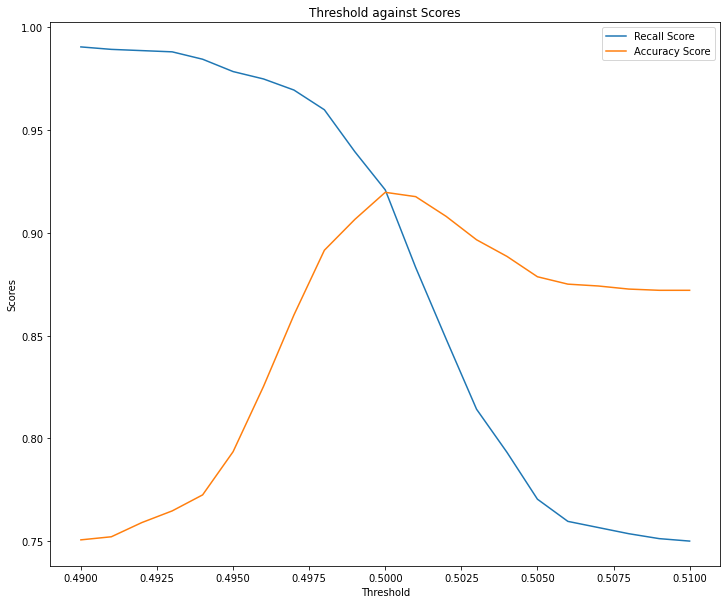

In [ ]:
plt.figure(figsize=(12,10))
plt.title('Threshold against Scores')
plt.plot(np.arange(0.49,0.51,0.001),ab_scores['recall scores'],label='Recall Score')
plt.plot(np.arange(0.49,0.51,0.001),ab_scores['accuracy scores'],label='Accuracy Score')
# plt.vlines(x=0.6,ymin=0,ymax=1,ls='--')
# plt.hlines(y=0.88,xmin=0,xmax=1,ls='--')
# plt.ylim(0,1)
# plt.xlim(0,1)
# plt.xticks(ticks=np.arange(0.1,1,0.1))
# plt.annotate(('Recall Value of 0.88'),xy=(0.6,0.88),xytext=(0.9, 0.8),arrowprops=dict(facecolor='grey'),horizontalalignment='right', verticalalignment='top')
# plt.annotate(('Accuracy Value of 0.83'),xy=(0.6,0.824),xytext=(0.9, 0.6),arrowprops=dict(facecolor='grey'),horizontalalignment='right', verticalalignment='top')
plt.xlabel('Threshold')
plt.ylabel('Scores')
plt.legend(loc='best')
plt.savefig('Recall against Scores')
plt.show()

In [ ]:
sm_y

array([False, False, False, ...,  True,  True,  True])

In [ ]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
kfold = kf.split(sm_X,sm_y)

In [ ]:
abscores = {
    'recall':[],
    'accu':[]
}
for k,(train,test) in enumerate(kfold):
    print(k,(train,test))
    ab.fit(sm_Xdf.iloc[train,:],sm_y[train])
    y_pred = ab.predict_proba(sm_Xdf.iloc[test,:])[:,1]>0.4975
    score = recall_score(sm_y[test],y_pred)
    acc_score = accuracy_score(sm_y[test],y_pred)
    abscores['recall'].append(score)
    abscores['accu'].append(acc_score)

0 (array([    0,     1,     3, ..., 16673, 16674, 16675]), array([    2,     4,     7, ..., 16661, 16665, 16671]))
1 (array([    0,     1,     2, ..., 16671, 16672, 16674]), array([    3,    19,    21, ..., 16670, 16673, 16675]))
2 (array([    1,     2,     3, ..., 16673, 16674, 16675]), array([    0,     5,     8, ..., 16641, 16646, 16672]))
3 (array([    0,     2,     3, ..., 16673, 16674, 16675]), array([    1,     9,    10, ..., 16667, 16668, 16669]))
4 (array([    0,     1,     2, ..., 16672, 16673, 16675]), array([    6,    11,    12, ..., 16625, 16655, 16674]))


In [ ]:
abscores

{'accu': [0.8794964028776978,
  0.8743628185907046,
  0.8770614692653673,
  0.8728635682158921,
  0.879160419790105],
 'recall': [0.9574340527577938,
  0.9622075584883023,
  0.967006598680264,
  0.9652278177458034,
  0.9628297362110312]}

In [ ]:
np.mean(abscores['recall'])

0.9629411527766388

In [ ]:
np.std(abscores['recall'],ddof=1)

0.0036275133330230876

In [ ]:
np.mean(abscores['accu'])

0.8765889357479534

In [ ]:
np.std(abscores['accu'],ddof=1)

0.0029207509334671956

# XGB Classifier

In [231]:
xgb = xgboost.XGBRFClassifier(max_depth=2,random_state=0,learning_rate=1,n_estimators=5000,n_jobs=-1,objective='binary:hinge')

In [232]:
xgb.fit(X_train,y_train)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=2, min_child_weight=1, missing=None,
                n_estimators=5000, n_jobs=-1, nthread=None,
                objective='binary:hinge', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                subsample=0.8, verbosity=1)

In [ ]:
# xgb = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Final Project/Online Shoppers Intention/Classifier Dumps/xgb classifier.pkl','rb'))
# xgb

In [233]:
y_pred = xgb.predict(X_test)

In [234]:
print(f'Accuracy Score for the XG Boosting Classifier is {accuracy_score(y_test,y_pred)}')
print(f'Recall Score for the XG Boosting Classifier is {recall_score(y_test,y_pred)}')

Accuracy Score for the XG Boosting Classifier is 0.8192446043165468
Recall Score for the XG Boosting Classifier is 0.9610311750599521


In [235]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.95      0.68      0.79      1668
        True       0.75      0.96      0.84      1668

    accuracy                           0.82      3336
   macro avg       0.85      0.82      0.82      3336
weighted avg       0.85      0.82      0.82      3336



In [ ]:
xgbscores = cross_val_score(xgb,sm_X,sm_y,scoring='recall',cv=cv,n_jobs=-1)

NameError: ignored

In [ ]:
print(f'Average Recall Score for Ada Boosting :{np.mean(xgbscores)}')
print(f'Variance in Recall Scores for Ada Boosting : {np.std(xgbscores,ddof=1)}')

Average Recall Score for Ada Boosting :0.924939184505644
Variance in Recall Scores for Ada Boosting : 0.023218486109472053


In [ ]:
xgbscores

array([0.93638171, 0.91554702, 0.95807453, 0.91784108, 0.89685157])

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.95      0.68      0.79      1668
        True       0.75      0.96      0.84      1668

    accuracy                           0.82      3336
   macro avg       0.85      0.82      0.82      3336
weighted avg       0.85      0.82      0.82      3336



In [238]:
splits = kf.split(sm_X,sm_y)
rcs = []
acc = []
for split,(train,test) in enumerate(splits):
  print(split,(train,test))
  xgb.fit(sm_X[train],sm_y[train])
  y_pred = xgb.predict(sm_X[test])
  rcs.append(recall_score(sm_y[test],y_pred))
  acc.append(accuracy_score(sm_y[test],y_pred))

0 (array([    0,     1,     3, ..., 16673, 16674, 16675]), array([    2,     4,     7, ..., 16661, 16665, 16671]))
1 (array([    0,     1,     2, ..., 16671, 16672, 16674]), array([    3,    19,    21, ..., 16670, 16673, 16675]))
2 (array([    1,     2,     3, ..., 16673, 16674, 16675]), array([    0,     5,     8, ..., 16641, 16646, 16672]))
3 (array([    0,     2,     3, ..., 16673, 16674, 16675]), array([    1,     9,    10, ..., 16667, 16668, 16669]))
4 (array([    0,     1,     2, ..., 16672, 16673, 16675]), array([    6,    11,    12, ..., 16625, 16655, 16674]))


In [239]:
print(f'XGB Classifier Average Accuracy Score:{np.mean(acc)}')
print(f'XGB Classifier Variance of Accuracy:{np.std(acc,ddof=1)}')

XGB Classifier Average Accuracy Score:0.8336531554366701
XGB Classifier Variance of Accuracy:0.005694696061272896


In [241]:
print(f'XGB Classifier Average Accuracy Score:{np.mean(rcs)}')
print(f'XGB Classifier Variance of Accuracy:{np.std(rcs,ddof=1)}')

XGB Classifier Average Accuracy Score:0.968218298786286
XGB Classifier Variance of Accuracy:0.00305108673739877


NameError: ignored

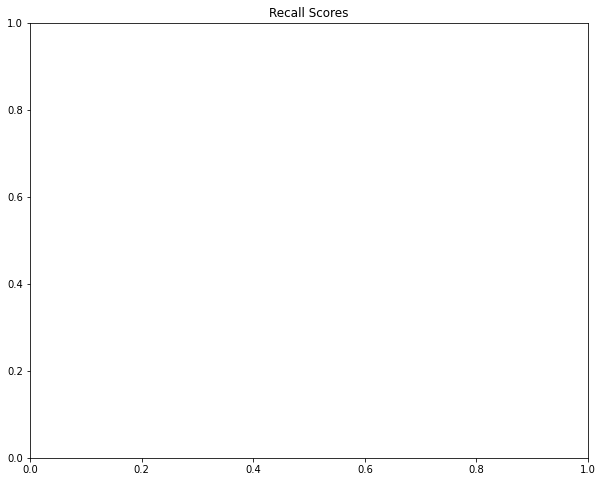

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Recall Scores')
plt.boxplot((rfscores,dtscores,lrscores,abscores['recall'],xgbscores),labels=['Random Forest','Decision Tree','Logistic Regression','Ada Boost Classifier','XGBoost Classifier'])
plt.yticks(np.arange(0.6,1.01,0.05))
plt.show()

In [ ]:
path = open('xgb classifier.pkl','wb')
pickle.dump(xgb,path)

In [ ]:
pd.DataFrame(y_valid).to_csv('y_valid.csv')

In [ ]:
X_valid

<2466x86 sparse matrix of type '<class 'numpy.float64'>'
	with 41922 stored elements in Compressed Sparse Row format>

In [ ]:
y_pred = xgb.predict(X_valid)

In [ ]:
accuracy_score(y_valid,y_pred)

0.7254663422546634

In [ ]:
recall_score(y_valid,y_pred)

0.9424083769633508

In [ ]:
X_valid

<2466x86 sparse matrix of type '<class 'numpy.float64'>'
	with 41922 stored elements in Compressed Sparse Row format>

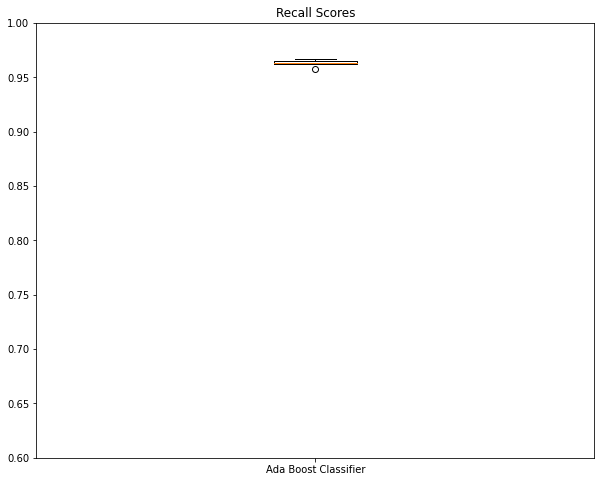

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Recall Scores')
plt.boxplot(abscores['recall'],labels=['Ada Boost Classifier'])
plt.yticks(np.arange(0.6,1.01,0.05))
plt.show()

# Support Vector Machines

In [193]:
svc = SVC(random_state=0)

In [187]:
svc.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [188]:
y_pred = svc.predict(X_test)

In [189]:
print(f'Support Vector Classifier Accuracy Score:{accuracy_score(y_test,y_pred)}')
print(f'Support Vector Classifier Recall Score:{recall_score(y_test,y_pred)}')

Support Vector Classifier Accuracy Score:0.8794964028776978
Support Vector Classifier Recall Score:0.8938848920863309


In [190]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.89      0.87      0.88      1668
        True       0.87      0.89      0.88      1668

    accuracy                           0.88      3336
   macro avg       0.88      0.88      0.88      3336
weighted avg       0.88      0.88      0.88      3336



***Grid Search CV***

In [ ]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

In [ ]:
params = {
    # 'kernel':['linear','poly','rbf','sigmoid'],
    'C':np.arange(0.0,1.1,0.1),
    # 'gamma':['scale','auto'],
    # 'degree':[1,2,3],
    # 'class_weight':['balanced']
}

In [ ]:
svc = SVC(kernel='rbf',random_state=0)

In [ ]:
gs = GridSearchCV(svc,params,scoring='accuracy',cv=skf,n_jobs=-1)

In [ ]:
gs.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=0, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
gs.best_params_

{'C': 1.0}

In [191]:
svc = gs.best_estimator_
svc

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [194]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
splits = kf.split(sm_X,sm_y)

In [195]:
rcs = []
acc = []
for split,(train,test) in enumerate(splits):
  print(split,(train,test))
  svc.fit(sm_X[train],sm_y[train])
  y_pred = svc.predict(sm_X[test])
  rcs.append(recall_score(sm_y[test],y_pred))
  acc.append(accuracy_score(sm_y[test],y_pred))

0 (array([    0,     1,     3, ..., 16673, 16674, 16675]), array([    2,     4,     7, ..., 16661, 16665, 16671]))
1 (array([    0,     1,     2, ..., 16671, 16672, 16674]), array([    3,    19,    21, ..., 16670, 16673, 16675]))
2 (array([    1,     2,     3, ..., 16673, 16674, 16675]), array([    0,     5,     8, ..., 16641, 16646, 16672]))
3 (array([    0,     2,     3, ..., 16673, 16674, 16675]), array([    1,     9,    10, ..., 16667, 16668, 16669]))
4 (array([    0,     1,     2, ..., 16672, 16673, 16675]), array([    6,    11,    12, ..., 16625, 16655, 16674]))


In [196]:
print(f'Support Vector Classifier Average Accuracy Score:{np.mean(acc)}')
print(f'Support Vector Classifier Variance of Accuracy:{np.std(acc,ddof=1)}')

Support Vector Classifier Average Accuracy Score:0.8841448520344144
Support Vector Classifier Variance of Accuracy:0.002031104135405102


In [197]:
print(f'Support Vector Classifier Average Recall Score:{np.mean(rcs)}')
print(f'Support Vector Classifier Variance of Recall:{np.std(rcs,ddof=1)}')

Support Vector Classifier Average Recall Score:0.8759893345071992
Support Vector Classifier Variance of Recall:0.004825879581167832


In [ ]:
np.mean(rcs)

0.8759893345071992

In [ ]:
np.std(rcs,ddof=1)

0.004825879581167832

In [ ]:
np.mean(acc)

0.8841448520344144

In [ ]:
np.std(acc,ddof=1)

0.002031104135405102

In [ ]:
pickle.dump(svc,open('Support Vector Classifier.pkl','wb'))

# KNearest Classifier

In [198]:
knc = KNeighborsClassifier(n_jobs=-1)

In [199]:
knc.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [200]:
y_pred = knc.predict(X_test)

In [201]:
print(f'KNeighbors Accuracy Score:{accuracy_score(y_test,y_pred)}')
print(f'KNeighbors Recall Score:{recall_score(y_test,y_pred)}')

KNeighbors Accuracy Score:0.8588129496402878
KNeighbors Recall Score:0.9718225419664268


In [ ]:
recall_score(y_test,y_pred)

0.9718225419664268

In [ ]:
accuracy_score(y_test,y_pred)

0.8588129496402878

In [ ]:
params = {
    'weights':['uniform','distance'],
    'n_neighbors':np.arange(3,20,2)
}

In [ ]:
kf

StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

In [ ]:
gs = GridSearchCV(knc,params,scoring='accuracy',n_jobs=-1,cv=kf)

In [ ]:
gs.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
gs.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

In [202]:
knc = KNeighborsClassifier(n_neighbors=3,weights='distance',n_jobs=-1)

In [203]:
knc.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='distance')

In [204]:
y_pred = knc.predict(X_test)

In [205]:
print(f'KNeighbors Accuracy Score:{accuracy_score(y_test,y_pred)}')
print(f'KNeighbors Recall Score:{recall_score(y_test,y_pred)}')

KNeighbors Accuracy Score:0.8872901678657075
KNeighbors Recall Score:0.9904076738609112


In [206]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.99      0.78      0.87      1668
        True       0.82      0.99      0.90      1668

    accuracy                           0.89      3336
   macro avg       0.90      0.89      0.89      3336
weighted avg       0.90      0.89      0.89      3336



In [207]:
splits = kf.split(sm_X,sm_y)
rcs = []
acc = []
for split,(train,test) in enumerate(splits):
  print(split,(train,test))
  knc.fit(sm_X[train],sm_y[train])
  y_pred = knc.predict(sm_X[test])
  rcs.append(recall_score(sm_y[test],y_pred))
  acc.append(accuracy_score(sm_y[test],y_pred))

0 (array([    0,     1,     3, ..., 16673, 16674, 16675]), array([    2,     4,     7, ..., 16661, 16665, 16671]))
1 (array([    0,     1,     2, ..., 16671, 16672, 16674]), array([    3,    19,    21, ..., 16670, 16673, 16675]))
2 (array([    1,     2,     3, ..., 16673, 16674, 16675]), array([    0,     5,     8, ..., 16641, 16646, 16672]))
3 (array([    0,     2,     3, ..., 16673, 16674, 16675]), array([    1,     9,    10, ..., 16667, 16668, 16669]))
4 (array([    0,     1,     2, ..., 16672, 16673, 16675]), array([    6,    11,    12, ..., 16625, 16655, 16674]))


In [208]:
print(f'KNeighbours Average Accuracy Score:{np.mean(acc)}')
print(f'KNieghbouts Variance of Accuracy:{np.std(acc,ddof=1)}')

KNeighbours Average Accuracy Score:0.896737728258173
KNieghbouts Variance of Accuracy:0.003167308773548507


In [209]:
print(f'KNeighbours Average Recall Score:{np.mean(rcs)}')
print(f'KNieghbouts Variance of Recall:{np.std(rcs,ddof=1)}')

KNeighbours Average Recall Score:0.9884860437984345
KNieghbouts Variance of Recall:0.0051151777186626566


In [ ]:
np.mean(rcs)

0.9884860437984345

In [ ]:
np.std(rcs,ddof=1)

0.0051151777186626566

In [ ]:
np.mean(acc)

0.896737728258173

In [ ]:
np.std(acc,ddof=1)

0.003167308773548507

In [ ]:
pickle.dump(knc,open('KNeighbors Classifier.pkl','wb'))

# Bagging Classifier

In [211]:
bc = BaggingClassifier(DecisionTreeClassifier(random_state=0),n_estimators=20,n_jobs=-1,random_state=0)

In [212]:
bc.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=0,
   

In [213]:
y_pred = bc.predict(X_test)

In [214]:
print(f'Bagging Classifier Accuracy Score:{accuracy_score(y_test,y_pred)}')
print(f'Bagging Classifer Recall Score:{recall_score(y_test,y_pred)}')

Bagging Classifier Accuracy Score:0.9256594724220624
Bagging Classifer Recall Score:0.9502398081534772


In [215]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.95      0.90      0.92      1668
        True       0.91      0.95      0.93      1668

    accuracy                           0.93      3336
   macro avg       0.93      0.93      0.93      3336
weighted avg       0.93      0.93      0.93      3336



In [ ]:
recall_score(y_test,y_pred)

0.9502398081534772

In [ ]:
accuracy_score(y_test,y_pred)

0.9256594724220624

In [216]:
splits = kf.split(sm_X,sm_y)
rcs = []
acc = []
for split,(train,test) in enumerate(splits):
  print(split,(train,test))
  bc.fit(sm_X[train],sm_y[train])
  y_pred = bc.predict(sm_X[test])
  rcs.append(recall_score(sm_y[test],y_pred))
  acc.append(accuracy_score(sm_y[test],y_pred))

0 (array([    0,     1,     3, ..., 16673, 16674, 16675]), array([    2,     4,     7, ..., 16661, 16665, 16671]))
1 (array([    0,     1,     2, ..., 16671, 16672, 16674]), array([    3,    19,    21, ..., 16670, 16673, 16675]))
2 (array([    1,     2,     3, ..., 16673, 16674, 16675]), array([    0,     5,     8, ..., 16641, 16646, 16672]))
3 (array([    0,     2,     3, ..., 16673, 16674, 16675]), array([    1,     9,    10, ..., 16667, 16668, 16669]))
4 (array([    0,     1,     2, ..., 16672, 16673, 16675]), array([    6,    11,    12, ..., 16625, 16655, 16674]))


In [217]:
print(f'Bagging Classifier Average Accuracy Score:{np.mean(acc)}')
print(f'Bagging Classifier Variance of Accuracy:{np.std(acc,ddof=1)}')

KNeighbours Average Accuracy Score:0.930679030988103
KNieghbouts Variance of Accuracy:0.005738595371688532


In [219]:
print(f'Bagging Classifier Average Recall Score:{np.mean(rcs)}')
print(f'Bagging Classifier Variance of Recall:{np.std(rcs,ddof=1)}')

Bagging Classifier Average Recall Score:0.9469881563255693
Bagging Classifier Variance of Recall:0.006700996038818823


In [ ]:
np.mean(rcs)

0.9469881563255693

In [ ]:
np.std(rcs,ddof=1)

0.006700996038818823

In [ ]:
np.mean(acc)

0.930679030988103

In [ ]:
np.std(acc,ddof=1)

0.005738595371688532

In [ ]:
pickle.dump(bc,open('Bagging Classifier.pkl','wb'))

# Gradient Boosting Classifier

In [174]:
gc = GradientBoostingClassifier(loss='exponential',n_estimators=500,max_depth=2,random_state=0)

In [175]:
gc.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [176]:
y_pred = gc.predict(X_test)

In [179]:
print(f'The Gradient Boost Classifier Accuracy Score:{accuracy_score(y_test,y_pred)}')
print(f'The Gradient Boost Classifier Recall Score:{recall_score(y_test,y_pred)}')

The Gradient Boost Classifier Accuracy Score:0.9229616306954437
The Gradient Boost Classifier Recall Score:0.934052757793765


In [180]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.93      0.91      0.92      1668
        True       0.91      0.93      0.92      1668

    accuracy                           0.92      3336
   macro avg       0.92      0.92      0.92      3336
weighted avg       0.92      0.92      0.92      3336



In [181]:
splits = kf.split(sm_X,sm_y)
rcs = []
acc = []
for split,(train,test) in enumerate(splits):
  print(split,(train,test))
  gc.fit(sm_X[train],sm_y[train])
  y_pred = gc.predict(sm_X[test])
  rcs.append(recall_score(sm_y[test],y_pred))
  acc.append(accuracy_score(sm_y[test],y_pred))

0 (array([    0,     1,     3, ..., 16673, 16674, 16675]), array([    2,     4,     7, ..., 16661, 16665, 16671]))
1 (array([    0,     1,     2, ..., 16671, 16672, 16674]), array([    3,    19,    21, ..., 16670, 16673, 16675]))
2 (array([    1,     2,     3, ..., 16673, 16674, 16675]), array([    0,     5,     8, ..., 16641, 16646, 16672]))
3 (array([    0,     2,     3, ..., 16673, 16674, 16675]), array([    1,     9,    10, ..., 16667, 16668, 16669]))
4 (array([    0,     1,     2, ..., 16672, 16673, 16675]), array([    6,    11,    12, ..., 16625, 16655, 16674]))


In [184]:
print(f'Gradient Boost Classifier Model Average Accuracy Score:{np.mean(acc)}')
print(f'Gradient Boost Classifier Model Variance of Accuracy Score:{np.std(acc,ddof=1)}')

Gradient Boost Classifier Model Average Accuracy Score:0.928400368161243
Gradient Boost Classifier Model Variance of Accuracy Score:0.00463675752191195


In [185]:
print(f'Gradient Boost Classifier Model Average Recall Score:{np.mean(rcs)}')
print(f'Gradient Boost Classifer Model Variance of Recall Scores:{np.std(rcs,ddof=1)}')

Gradient Boost Classifier Model Average Recall Score:0.9343967177787464
Gradient Boost Classifer Model Variance of Recall Scores:0.0040798942809289335


In [ ]:
np.std(rcs,ddof=1)

0.005744271579371869

In [ ]:
np.mean(acc)

0.9207244758915506

In [ ]:
np.std(acc,ddof=1)

0.0045337473999462734

In [ ]:
pickle.dump(gc,open('Gradient Boost Classifier.pkl','wb'))

# Linear Discriminant Analysis

In [ ]:
lda = LinearDiscriminantAnalysis()

In [ ]:
lda.fit(X_train.toarray(),y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [ ]:
y_pred = lda.predict(X_test.toarray())

In [ ]:
recall_score(y_test,y_pred)

0.7721822541966427

In [ ]:
accuracy_score(y_test,y_pred)

0.7742805755395683

In [ ]:
splits = kf.split(sm_X,sm_y)
rcs = []
acc = []
for split,(train,test) in enumerate(splits):
  print(split,(train,test))
  lda.fit(sm_X[train].toarray(),sm_y[train])
  y_pred = lda.predict(sm_X[test].toarray())
  rcs.append(recall_score(sm_y[test],y_pred))
  acc.append(accuracy_score(sm_y[test],y_pred))

0 (array([    0,     1,     3, ..., 16673, 16674, 16675]), array([    2,     4,     7, ..., 16661, 16665, 16671]))
1 (array([    0,     1,     2, ..., 16671, 16672, 16674]), array([    3,    19,    21, ..., 16670, 16673, 16675]))
2 (array([    1,     2,     3, ..., 16673, 16674, 16675]), array([    0,     5,     8, ..., 16641, 16646, 16672]))
3 (array([    0,     2,     3, ..., 16673, 16674, 16675]), array([    1,     9,    10, ..., 16667, 16668, 16669]))
4 (array([    0,     1,     2, ..., 16672, 16673, 16675]), array([    6,    11,    12, ..., 16625, 16655, 16674]))


In [ ]:
np.mean(rcs)

0.7765640397100435

In [ ]:
np.std(rcs,ddof=1)

0.009676412254313304

In [ ]:
np.mean(acc)

0.7900572555448895

In [ ]:
np.std(acc,ddof=1)

0.007335420811463184

In [ ]:
pickle.dump(lda,open('Linear Discriminant Analysis.pkl','wb'))

# Gaussian Naive Bayes

In [221]:
gnb = GaussianNB()

In [222]:
gnb.fit(X_train.toarray(),y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [223]:
y_pred = gnb.predict(X_test.toarray())

In [224]:
print(f'The GNB Classifier Accuracy Score:{accuracy_score(y_test,y_pred)}')
print(f'The GNB Classifier Recall Score:{recall_score(y_test,y_pred)}')

The GNB Classifier Accuracy Score:0.6019184652278178
The GNB Classifier Recall Score:0.959832134292566


In [225]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.86      0.24      0.38      1668
        True       0.56      0.96      0.71      1668

    accuracy                           0.60      3336
   macro avg       0.71      0.60      0.54      3336
weighted avg       0.71      0.60      0.54      3336



In [ ]:
recall_score(y_test,y_pred)

0.959832134292566

In [ ]:
accuracy_score(y_test,y_pred)

0.6019184652278178

In [226]:
splits = kf.split(sm_X,sm_y)
rcs = []
acc = []
for split,(train,test) in enumerate(splits):
  print(split,(train,test))
  gnb.fit(sm_X[train].toarray(),sm_y[train])
  y_pred = gnb.predict(sm_X[test].toarray())
  rcs.append(recall_score(sm_y[test],y_pred))
  acc.append(accuracy_score(sm_y[test],y_pred))

0 (array([    0,     1,     3, ..., 16673, 16674, 16675]), array([    2,     4,     7, ..., 16661, 16665, 16671]))
1 (array([    0,     1,     2, ..., 16671, 16672, 16674]), array([    3,    19,    21, ..., 16670, 16673, 16675]))
2 (array([    1,     2,     3, ..., 16673, 16674, 16675]), array([    0,     5,     8, ..., 16641, 16646, 16672]))
3 (array([    0,     2,     3, ..., 16673, 16674, 16675]), array([    1,     9,    10, ..., 16667, 16668, 16669]))
4 (array([    0,     1,     2, ..., 16672, 16673, 16675]), array([    6,    11,    12, ..., 16625, 16655, 16674]))


In [229]:
print(f'GNB Classifier Model Average Accuracy Score:{np.mean(acc)}')
print(f'GNB Classifier Model Variance of Accuracy Score:{np.std(acc,ddof=1)}')

GNB Classifier Model Average Accuracy Score:0.6012832612470744
GNB Classifier Model Variance of Accuracy Score:0.006166211705098695


In [230]:
print(f'GNB Classifier Model Average Recall Score:{np.mean(rcs)}')
print(f'GNB Classifier Model Variance of Recall Score:{np.std(rcs,ddof=1)}')

GNB Classifier Model Average Recall Score:0.9588608896925649
GNB Classifier Model Variance of Recall Score:0.009816645145161326


In [227]:
np.mean(rcs)

0.9588608896925649

In [228]:
np.std(rcs,ddof=1)

0.009816645145161326

In [ ]:
np.mean(acc)

0.6012832612470744

In [ ]:
np.std(acc,ddof=1)

0.006166211705098695

In [ ]:
pickle.dump(gnb,open('Gaussian Naive Bayes Classifier.pkl','wb'))

# KMeans Clustering 

In [ ]:
km = KMeans(n_clusters=2,n_jobs=-1)

In [ ]:
km.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
km.inertia_

127911.97531356642

In [ ]:
pd.DataFrame(km.cluster_centers_)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85
0,0.002069,0.943403,0.054528,0.0,0.998263,0.001737,0.000729,0.986514,0.012756,0.919315,0.011544,0.016192,0.022708,0.020252,0.009988,0.033865,0.120162,0.008702,0.035273,0.019668,0.138862,0.237323,0.321942,0.046668,0.037535,0.204262,0.560046,0.191679,0.037251,0.000593,0.000690,0.000345,0.005133,0.195907,0.658720,0.006622,0.059649,0.034085,0.012934,0.003773,...,0.413847,0.090417,0.196620,0.087832,0.023125,0.061177,0.056733,0.032694,0.037554,0.189602,0.360683,0.148022,0.082704,0.021991,0.031070,0.003087,0.031593,0.003165,0.038233,0.021784,0.000086,0.048393,0.000882,0.002243,0.000523,0.000086,0.000604,0.001122,0.014127,0.133814,0.004969,0.861216,0.763735,0.236265,0.076478,0.073383,0.166964,-0.104448,-0.140114,-0.002604
1,0.000000,0.979509,0.020491,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,0.984498,0.006590,0.000300,0.006668,0.000000,0.001944,0.051009,0.170284,0.000000,0.015482,0.014167,0.109415,0.241567,0.311743,0.057541,0.028794,0.191933,0.674862,0.061169,0.041994,0.000000,0.002047,0.000000,0.027996,0.189087,0.656218,0.001118,0.055124,0.039342,0.005764,0.000572,...,0.465620,0.101272,0.138129,0.089465,0.031970,0.038285,0.058232,0.012505,0.064523,0.074012,0.520165,0.084091,0.084372,0.033671,0.026376,0.009405,0.056807,0.003277,0.032063,0.012684,0.000000,0.007188,0.000572,0.000000,0.000000,0.000000,0.000000,0.001504,0.053815,0.371609,0.027996,0.600395,0.766200,0.233800,-0.012007,-0.118655,-0.052493,-0.416953,-0.611603,3.478293


In [ ]:
y_class = km.labels_

In [ ]:
y_class = [False if i==0 else True for i in y_class]

In [ ]:
y_train

array([False,  True, False, ..., False, False, False])

In [ ]:
accuracy_score(y_train,y_class)

0.6199400299850075

In [ ]:
recall_score(y_train,y_class)

0.25112443778110943

# PCA Clustering

In [ ]:
len(pd.DataFrame(X_train.todense()).columns)

86

In [ ]:
pc = PCA(n_components=86,random_state=0)

In [ ]:
X_pca = pc.fit_transform(X_train.toarray())

In [ ]:
pc.explained_variance_

array([2.36838124e+00, 1.88941814e+00, 1.06580252e+00, 8.45716022e-01,
       8.00467537e-01, 5.16133432e-01, 3.55464454e-01, 3.22031755e-01,
       2.82428206e-01, 2.58275416e-01, 2.40027109e-01, 2.01935680e-01,
       1.86466779e-01, 1.34290098e-01, 1.31853878e-01, 1.21602841e-01,
       1.03224823e-01, 8.87472332e-02, 8.17982785e-02, 6.87982986e-02,
       6.73738936e-02, 6.45404256e-02, 5.60321194e-02, 5.29791756e-02,
       5.26795064e-02, 5.04801528e-02, 4.76937071e-02, 4.55481564e-02,
       3.99672616e-02, 3.83685840e-02, 3.47590639e-02, 3.26596297e-02,
       3.14484671e-02, 3.06659626e-02, 2.93992468e-02, 2.63597838e-02,
       2.62363632e-02, 2.31923125e-02, 2.18221622e-02, 2.01158038e-02,
       1.86190815e-02, 1.85621128e-02, 1.82310226e-02, 1.56605618e-02,
       1.50857465e-02, 1.36421760e-02, 1.18437777e-02, 1.11551569e-02,
       8.87197653e-03, 8.58098981e-03, 7.54889689e-03, 7.13930444e-03,
       5.56401540e-03, 3.60680725e-03, 3.26515251e-03, 2.92317311e-03,
      

In [ ]:
np.cumsum(pc.explained_variance_ratio_[:28])

array([0.21448089, 0.38558683, 0.48210603, 0.55869418, 0.63118462,
       0.67792572, 0.71011663, 0.73927986, 0.76485659, 0.78824605,
       0.80998293, 0.82827025, 0.8451567 , 0.85731803, 0.86925873,
       0.8802711 , 0.88961915, 0.89765611, 0.90506378, 0.91129416,
       0.91739555, 0.92324034, 0.92831461, 0.93311241, 0.93788307,
       0.94245456, 0.94677371, 0.95089856])

In [ ]:
X_pca[:,:28].shape

(13340, 28)

In [ ]:
X_pca = X_pca[:,:28]

In [ ]:
km.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
y_class = km.labels_

In [ ]:
y_class = [False if i==0 else True for i in y_class]

In [ ]:
recall_score(y_train,y_class)

0.2512743628185907

In [ ]:
accuracy_score(y_train,y_class)

0.6200149925037481

# Agglomerative Clustering

In [ ]:
agc = AgglomerativeClustering(linkage='ward')

In [ ]:
agc.fit(X_pca)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2)

In [ ]:
y_class = agc.labels_

In [ ]:
y_class = [False if i==0 else True for i in y_class]

In [ ]:
recall_score(y_train,y_class)

0.38185907046476764

In [ ]:
accuracy_score(y_train,y_class)

0.6786356821589206